# Outlier analysis

The purpose of this notebook is to analyze the dataset of Human, to find potential outliers.

## Imports

In [6]:
from subpred.transporter_dataset import create_dataset
from subpred.compositions import calculate_aac, calculate_paac
from subpred.plots import (
    labeled_clustermap,
    corr_heatmap,
    pca_plot_2d,
    pca_plot_3d,
)
from subpred.util import get_clusters, perform_pca, get_protein_feature_stats
import numpy as np

## Creating the dataset

The dataset with outliers and no clustering:

In [7]:
df = create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "keep",
    verbose = True,
    tax_ids_filter = [3702, 9606, 83333, 559292],
    output_log = "../logs/meta_amino_sugar_dataset.log",
)
taxid_to_organism = {
    3702: "A. thaliana",
    9606: "Human",
    83333: "E. coli",
    559292: "Yeast"
}
df = df.assign(organism = df.organism_id.map(taxid_to_organism)) 

In [8]:
df.head()

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence,organism
Uniprot,,,,,,,,,,
P0CD99,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,MPH2 YDL247W,Alpha-glucosides permease MPH2 (Maltose transp...,NaN,0.0,559292,MKNLSFLINRRKENTSDSNVYPGKAKSHEPSWIEMDDQTKKDGLDI...,Yeast
P69801,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,manY pel ptsP b1818 JW1807,PTS system mannose-specific EIIC component (EI...,4.A.6.1.1,4.A,83333,MEITTLQIVLVFIVACIAGMGSILDEFQFHRPLIACTLVGIVLGDM...,E. coli
Q9SFG0,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP6 At3g05960 F2O10.8,Sugar transport protein 6 (Hexose transporter 6),2.A.1.1.56,2.A,3702,MAVVVSNANAPAFEAKMTVYVFICVMIAAVGGLIFGYDIGISGGVS...,A. thaliana
Q9BWM7,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SFXN3,Sideroflexin-3,NaN,0.0,9606,MGELPLDINIQEPRWDQSTFLGRARHFFTVTDPRNLLLSGAQLEAS...,Human
Q9ZVK6,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,SUC8 At2g14670 T6B13.9,Sucrose transport protein SUC8 (Sucrose permea...,NaN,0.0,3702,MSDLQAKNDVVAVDRQSSSSLADLDGPSPLRKMISVASIAAGIQFG...,A. thaliana


In [9]:
df_aac = calculate_aac(df.sequence)
df_paac = calculate_paac(df.sequence)

## Organism comparison

In terms of AAC, the organisms form clusters, but also with overlap. The cluster that appears most clearly is that of E Coli in the lower left.

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

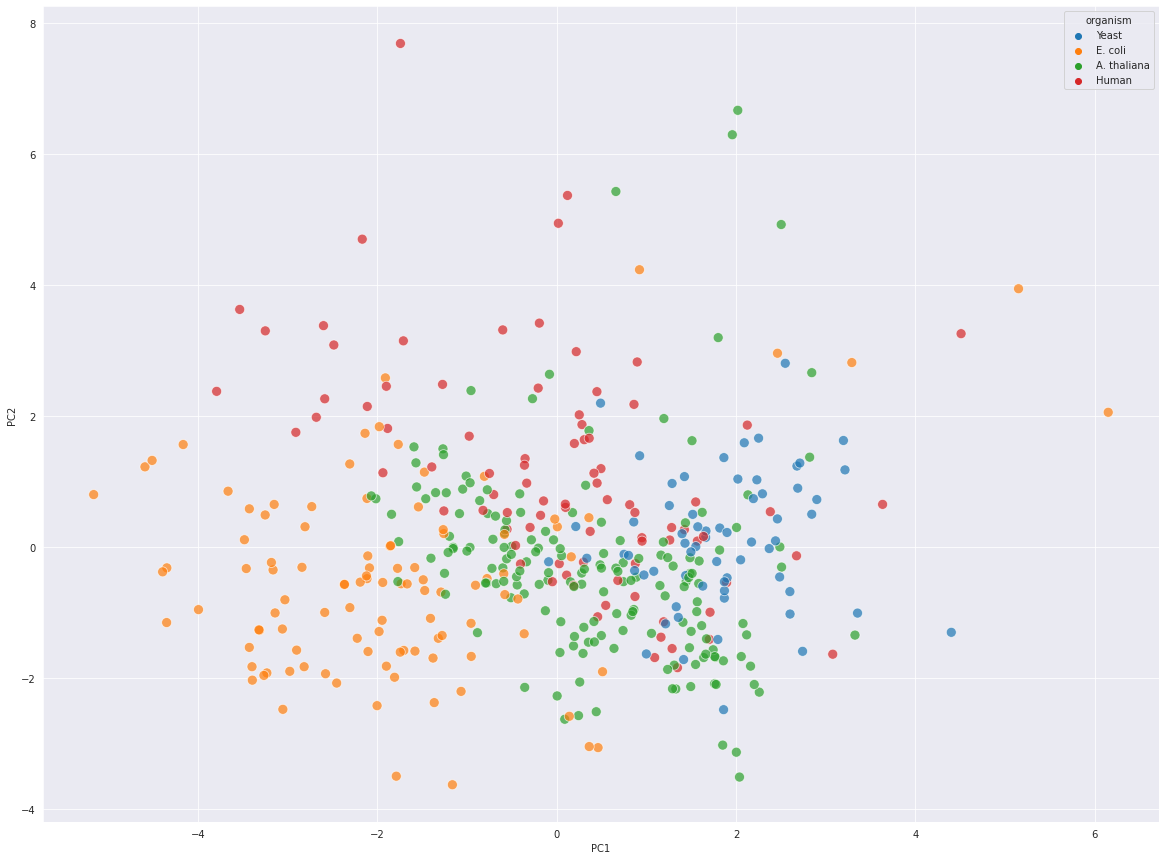

In [10]:
pca_plot_2d(
    df_aac,
    # df.keywords_location,
    df.organism,
    figsize=(20, 15),
    marker_size=100,
    marker_opacity=0.7,
)

The same is true with PAAC:

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

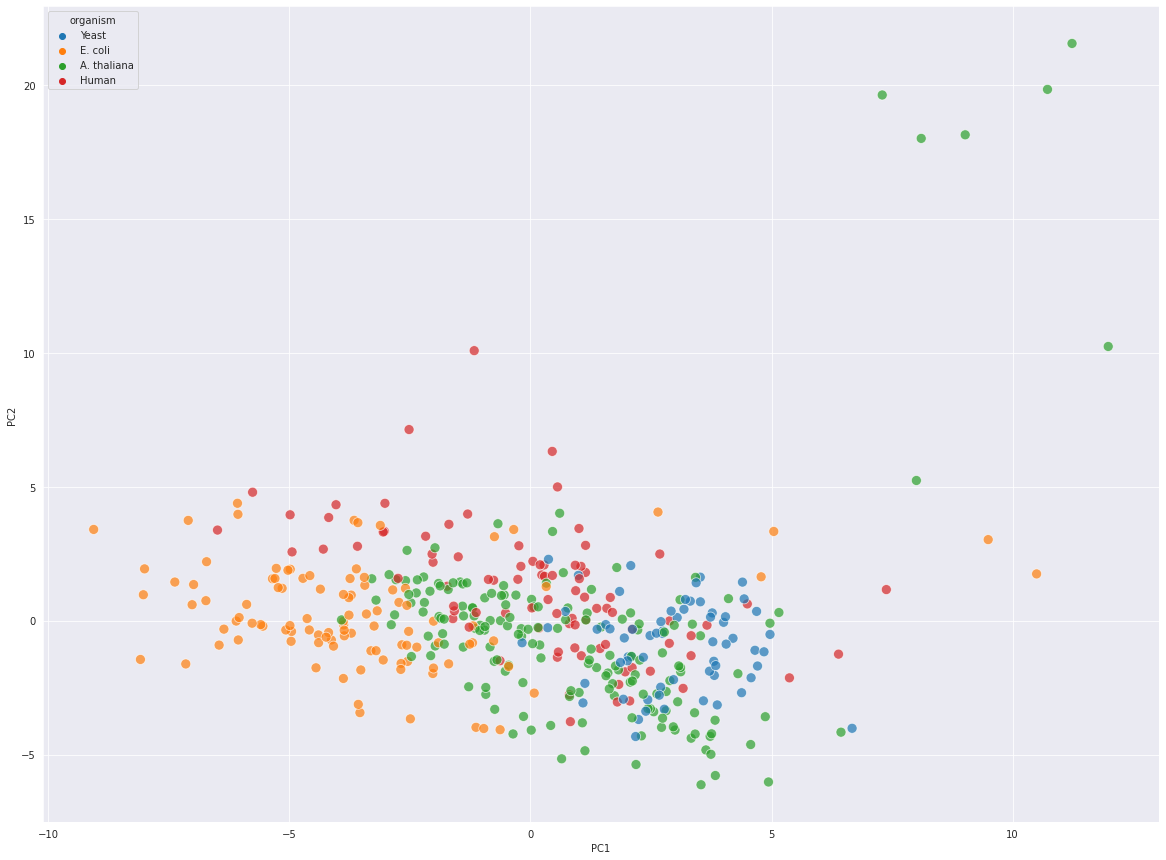

In [11]:
pca_plot_2d(
    df_paac,
    # df.keywords_location,
    df.organism,
    figsize=(20, 15),
    marker_size=100,
    marker_opacity=0.7,
)

### Stats

In contrast to the individual organsims, the dataset now has more than enough transporters in each class. The downside could be the increased variance between them.

In [12]:
df.keywords_transport.value_counts()

Sugar transport                                                                   223
Amino-acid transport                                                              176
Amino-acid transport;Ion transport;Sodium transport                                11
Ion transport;Sugar transport                                                       4
Ion transport;Sodium transport;Sugar transport                                      4
Amino-acid transport;Chloride                                                       4
Amino-acid transport;Neurotransmitter transport                                     3
Amino-acid transport;Ion transport;Neurotransmitter transport;Sodium transport      1
Ion transport;Polysaccharide transport;Sugar transport                              1
Phosphate transport;Sugar transport                                                 1
Name: keywords_transport, dtype: int64

Let's plot the different substrate combinations using the PAAC feature:

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

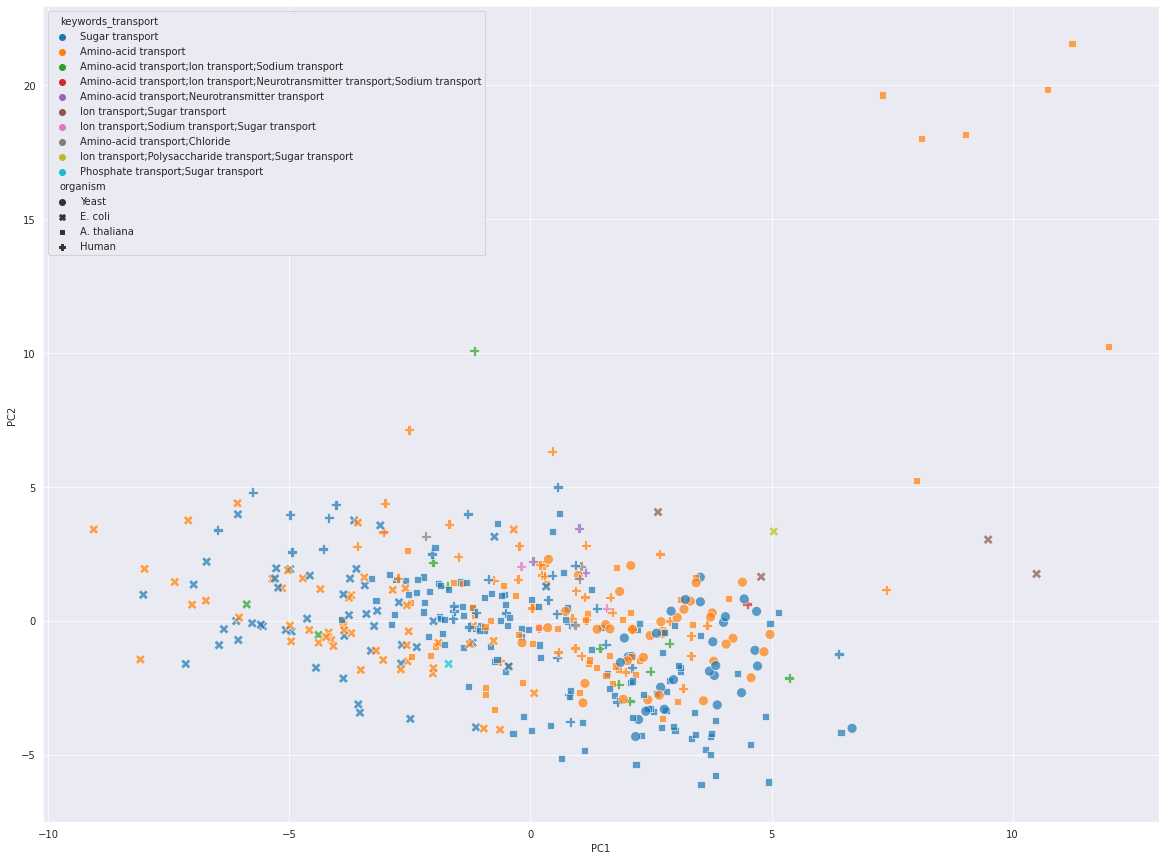

In [13]:
pca_plot_2d(
    df_paac,
    df.keywords_transport,
    figsize=(20, 15),
    marker_size=100,
    marker_opacity=0.7,
    labels2=df.organism,
)

What are the proteins with high value on PC1?

In [14]:
df.loc[perform_pca(df_paac, df.keywords_transport).query("PC1 > 7").index]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence,organism
Uniprot,,,,,,,,,,
P76773,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,ompL yshA b3875 JW3846,Porin OmpL,1.B.35.2.2,1.B,83333,MKKINAIILLSSLTSASVFAGAYVENREAYNLASDQGEVMLRVGYN...,E. coli
Q07837,Amino-acid transport,Membrane;Transmembrane,Transport,SLC3A1 RBAT,Neutral and basic amino acid transport protein...,8.A.9.1.2,8.A,9606,MAEDKSKRDSIEMSMKGCQTNNGFVHNEDILEQTPDPGSSTDNLKH...,Human
P69856,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,nanC yjhA b4311 JW5778,Probable N-acetylneuraminic acid outer membran...,1.B.35.2.1,1.B,83333,MKKAKILSGVLLLCFSSPLISQAATLDVRGGYRSGSHAYETRLKVS...,E. coli
O81775,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,GDU1 At4g31730 F28M20.80,Protein GLUTAMINE DUMPER 1,1.A.41.2.2,1.A,3702,MRPLSVQSKFEDVATSTSVNHHGVTPQSPWHSPVPYLFGGLAAMLG...,A. thaliana
Q9SW07,Amino-acid transport,Membrane;Transmembrane,Transport,GDU2 At4g25760 F14M19.40,Protein GLUTAMINE DUMPER 2,NaN,0.0,3702,MQTMEGRQYNYQDSINASSSMVVPHSPWHSPVPYLFGGLAAMLALI...,A. thaliana
Q9FHH5,Amino-acid transport,Membrane;Transmembrane,Transport,GDU3 LBS1 At5g57685 MRI1.4,Protein GLUTAMINE DUMPER 3 (Protein LESS SUSCE...,NaN,0.0,3702,MEGRQYYPPRENVEGNRTTMGGGPHSPWHSPVPYLFGGLAAMLGLI...,A. thaliana
Q8S8A0,Amino-acid transport,Membrane;Transmembrane,Transport,GDU4 At2g24762 F27A10.11,Protein GLUTAMINE DUMPER 4,NaN,0.0,3702,MRPLSIKPTSLDVARHATSVESFGNHRPPISPWHSPVPYLFGGLAA...,A. thaliana
Q3E965,Amino-acid transport,Membrane;Transmembrane,Transport,GDU5 At5g24920 F6A4.130,Protein GLUTAMINE DUMPER 5,NaN,0.0,3702,MRQFPSIRGNINEKMMTTMVESQTRSPWRTPVPYLFGGLAAMLGLI...,A. thaliana
Q3EAV6,Amino-acid transport,Membrane;Transmembrane,Transport,GDU6 At3g30725 T4A2.7,Protein GLUTAMINE DUMPER 6,NaN,0.0,3702,MRPTPKVEIWKSPVPYLFGGLFLLVLLIALALLSLVCTHQKPSSSS...,A. thaliana


These are the AT GDU proteins and the EC Porins again, that we also classified as outliers for the individual organism datasets. Also there is RBAT, which we classified as an outlier for human. The other outlier in Human shows a high PC2 value:

In [15]:
df.loc[perform_pca(df_paac, df.keywords_transport).query("PC2 > 8").index]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence,organism
Uniprot,,,,,,,,,,
Q9HBR0,Amino-acid transport;Ion transport;Sodium tran...,Membrane;Transmembrane,Transport,SLC38A10 PP1744,Putative sodium-coupled neutral amino acid tra...,2.A.18.6.16,2.A,9606,MTAAAASNWGLITNIVNSIVGVSVLTMPFCFKQCGIVLGALLLVFC...,Human
O81775,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,GDU1 At4g31730 F28M20.80,Protein GLUTAMINE DUMPER 1,1.A.41.2.2,1.A,3702,MRPLSVQSKFEDVATSTSVNHHGVTPQSPWHSPVPYLFGGLAAMLG...,A. thaliana
Q9SW07,Amino-acid transport,Membrane;Transmembrane,Transport,GDU2 At4g25760 F14M19.40,Protein GLUTAMINE DUMPER 2,NaN,0.0,3702,MQTMEGRQYNYQDSINASSSMVVPHSPWHSPVPYLFGGLAAMLALI...,A. thaliana
Q9FHH5,Amino-acid transport,Membrane;Transmembrane,Transport,GDU3 LBS1 At5g57685 MRI1.4,Protein GLUTAMINE DUMPER 3 (Protein LESS SUSCE...,NaN,0.0,3702,MEGRQYYPPRENVEGNRTTMGGGPHSPWHSPVPYLFGGLAAMLGLI...,A. thaliana
Q8S8A0,Amino-acid transport,Membrane;Transmembrane,Transport,GDU4 At2g24762 F27A10.11,Protein GLUTAMINE DUMPER 4,NaN,0.0,3702,MRPLSIKPTSLDVARHATSVESFGNHRPPISPWHSPVPYLFGGLAA...,A. thaliana
Q3E965,Amino-acid transport,Membrane;Transmembrane,Transport,GDU5 At5g24920 F6A4.130,Protein GLUTAMINE DUMPER 5,NaN,0.0,3702,MRQFPSIRGNINEKMMTTMVESQTRSPWRTPVPYLFGGLAAMLGLI...,A. thaliana
Q3EAV6,Amino-acid transport,Membrane;Transmembrane,Transport,GDU6 At3g30725 T4A2.7,Protein GLUTAMINE DUMPER 6,NaN,0.0,3702,MRPTPKVEIWKSPVPYLFGGLFLLVLLIALALLSLVCTHQKPSSSS...,A. thaliana


#### Locations

In [16]:
df.keywords_location.value_counts()

Membrane;Transmembrane                                               190
Cell inner membrane;Cell membrane;Membrane;Transmembrane              99
Cell membrane;Membrane;Transmembrane                                  98
Endoplasmic reticulum;Membrane;Transmembrane                          19
Membrane;Mitochondrion;Transmembrane                                   9
Cell outer membrane;Membrane;Transmembrane                             5
Cell membrane;Endoplasmic reticulum;Membrane;Transmembrane             3
Membrane;Mitochondrion;Mitochondrion inner membrane;Transmembrane      3
Membrane;Plastid inner membrane;Transmembrane                          1
Cell membrane;Membrane;Nucleus;Transmembrane                           1
Name: keywords_location, dtype: int64

In terms of location, we can see a clear difference between the orange (non-channel) and grey (channel) E coli transporters. Most E Coli transporters are annotated with the same location, which shows the E Coli cluster clearly again:

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

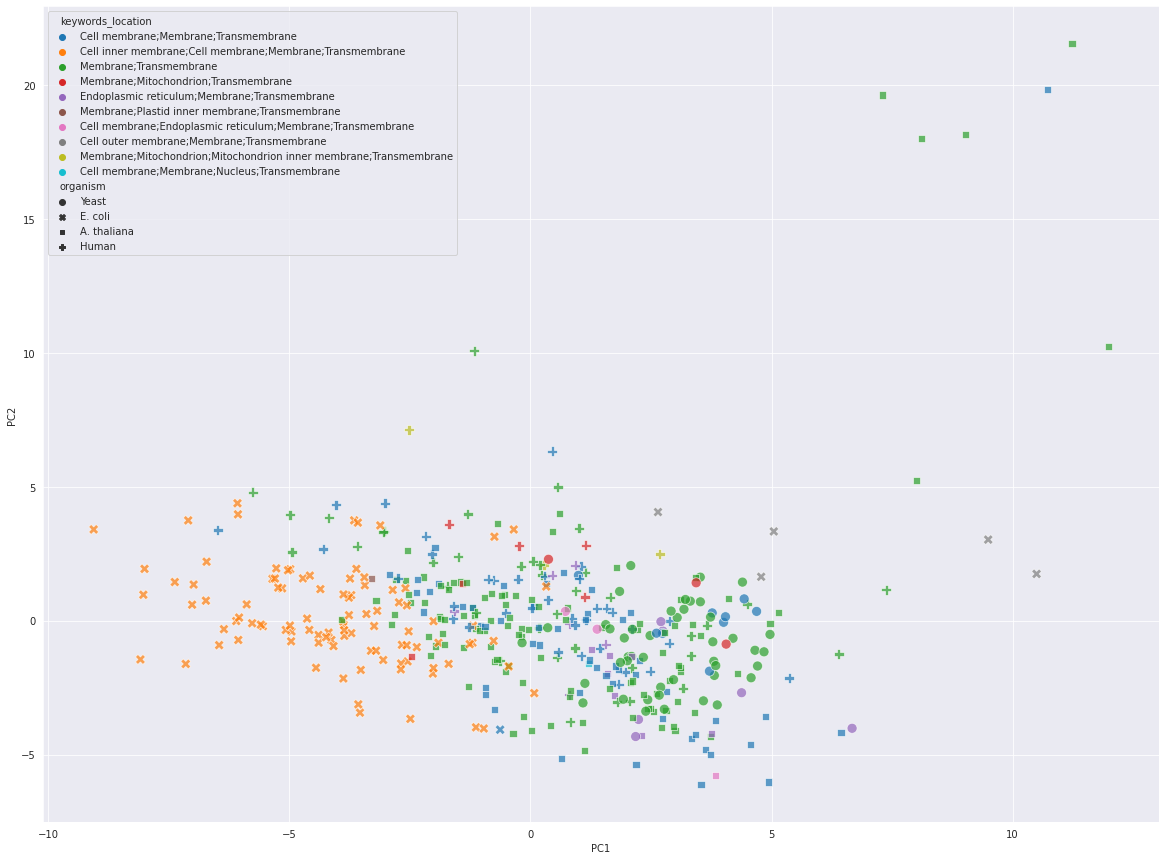

In [17]:
pca_plot_2d(
    df_paac,
    df.keywords_location,
    df.organism,
    figsize=(20, 15),
    marker_size=100,
    marker_opacity=0.7,
)

With regards to other keywords, only the porins stick out:

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

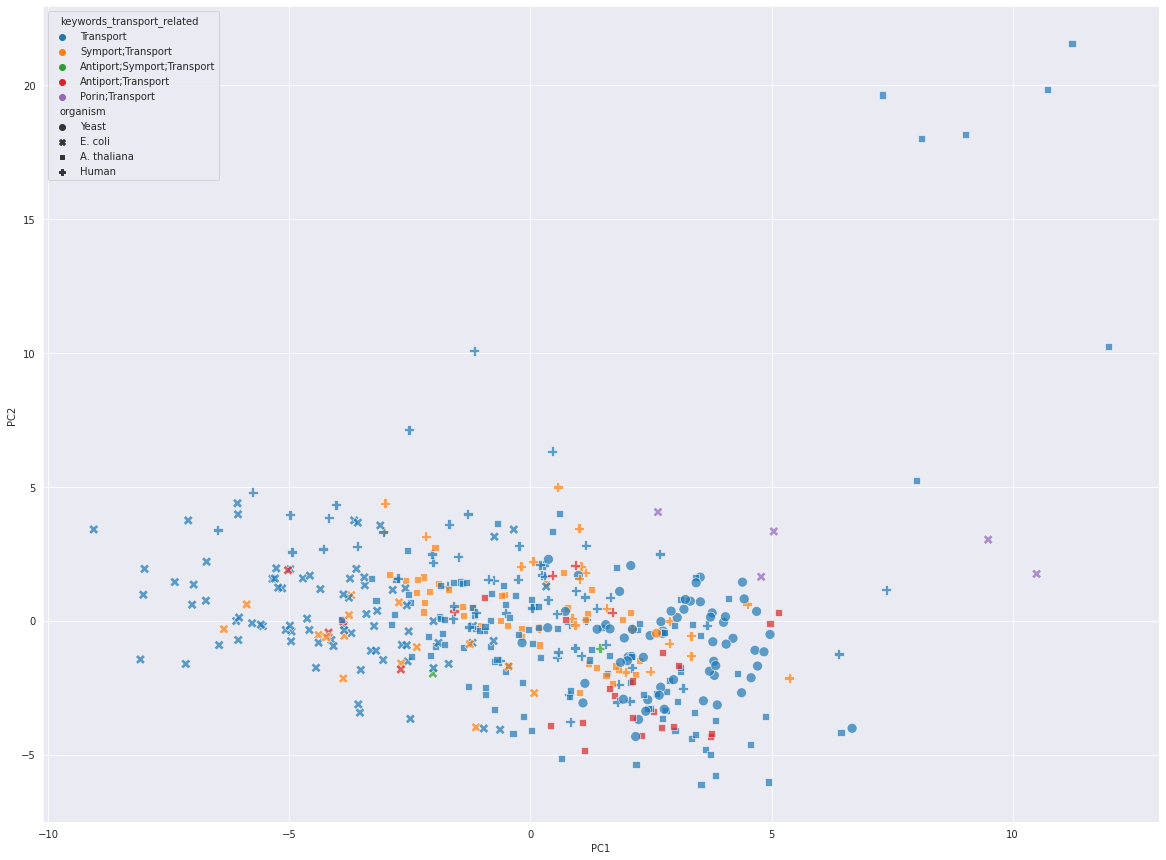

In [18]:
pca_plot_2d(
    df_paac,
    df.keywords_transport_related,
    df.organism,
    figsize=(20, 15),
    marker_size=100,
    marker_opacity=0.7,
)

In terms of sequence PCA, nothing seems to stand out.

#### TCDB

This dataset is almost completely annotated with TCDB identifiers. Almost all of them are passive transporters in class 2.A. The class 8 protein is RBAT, which we already found earlier.

In [19]:
df.tcdb_class.value_counts()

2.A    251
0.0    130
3.A     23
4.A     17
1.B      5
8.A      1
1.A      1
Name: tcdb_class, dtype: int64

The 1.A transporter is GDU1, with the remaining GDU proteins being unclassified paralogs.

In [20]:
df.query("tcdb_class == '1.A'")

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence,organism
Uniprot,,,,,,,,,,
O81775,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,GDU1 At4g31730 F28M20.80,Protein GLUTAMINE DUMPER 1,1.A.41.2.2,1.A,3702,MRPLSVQSKFEDVATSTSVNHHGVTPQSPWHSPVPYLFGGLAAMLG...,A. thaliana


What is the protein with TCDB 8?

In [21]:
df[df.tcdb_class.str.startswith("8")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence,organism
Uniprot,,,,,,,,,,
Q07837,Amino-acid transport,Membrane;Transmembrane,Transport,SLC3A1 RBAT,Neutral and basic amino acid transport protein...,8.A.9.1.2,8.A,9606,MAEDKSKRDSIEMSMKGCQTNNGFVHNEDILEQTPDPGSSTDNLKH...,Human


This is the human outlier protein. What does the PCA look like?

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

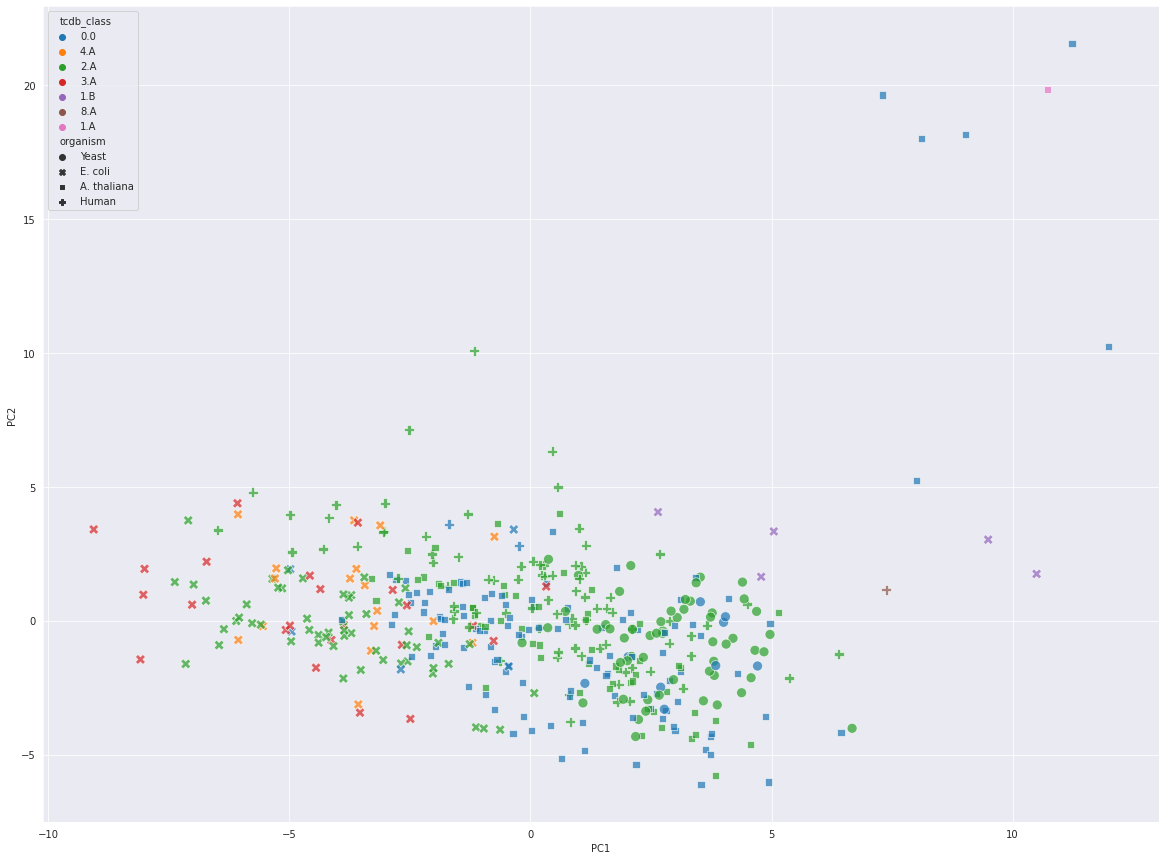

In [22]:
pca_plot_2d(
    df_paac,
    df.tcdb_class,
    df.organism,
    figsize=(20, 15),
    marker_size=100,
    marker_opacity=0.7,
)

The active transporters and group translocators correlate with E Coli, as that is the organism where they occur almost exclusively. The channels are outliers or unclassified (0.0). The remaining transporters are in one cluster.

({'A. thaliana': 'cyan',
  'E. coli': 'magenta',
  'Human': 'yellow',
  'Yeast': 'green'},
 <seaborn.matrix.ClusterGrid at 0x7f7da99d33a0>)

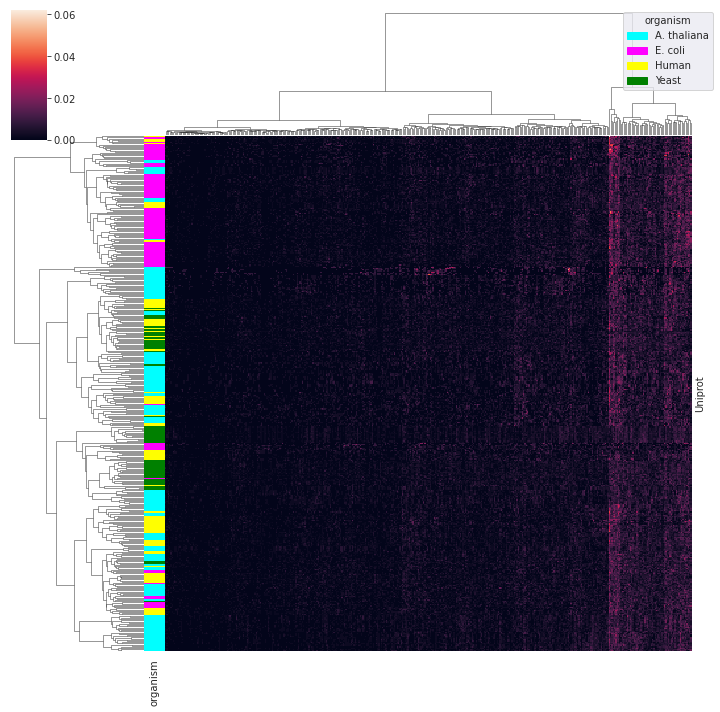

In [23]:
# labeled_clustermap(df_paac, df.tcdb_class)
labeled_clustermap(df_paac, df.organism)

Which eukaryotic transporters are in the same cluster as most E Coli transporters? Are they MT or chloroplast transporters, since proteins there are more likely to be related to prokaryotes?

In [24]:
cluster1, cluster2 = get_clusters(df_paac, 2)

df.loc[cluster2].query("organism != 'E. coli'")

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence,organism
Uniprot,,,,,,,,,,
Q9ZVK6,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,SUC8 At2g14670 T6B13.9,Sucrose transport protein SUC8 (Sucrose permea...,NaN,0.0,3702,MSDLQAKNDVVAVDRQSSSSLADLDGPSPLRKMISVASIAAGIQFG...,A. thaliana
Q56ZZ7,Sugar transport,Membrane;Plastid inner membrane;Transmembrane,Transport,At5g16150 T21H19.70,Plastidic glucose transporter 4 (AtpGlcT),2.A.1.1.102,2.A,3702,MQSSTYAVKGNAAFAFQRRTFSSDRSTTSTGIRFAGYKSLATTGPL...,A. thaliana
P92962,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,PROT2 At3g55740 F1I16.150,Proline transporter 2 (AtPROT2),NaN,0.0,3702,MDTSEARNRKVVAVEQFDLEVPETAHQISSDSWFQVAFVLTTGINS...,A. thaliana
Q39232,Sugar transport,Membrane;Transmembrane,Symport;Transport,SUC1 At1g71880 F17M19.3,Sucrose transport protein SUC1 (Sucrose permea...,2.A.2.4.1,2.A,3702,MGAYETEKPTKDAAALETQSPEDFDQPSPLRKIISVASIAAGVQFG...,A. thaliana
P92961,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,PROT1 At2g39890 T28M21.5,Proline transporter 1 (AtPROT1),2.A.18.3.1,2.A,3702,MTATEAKNRKINVGDGDDVVDIEIPDTAHQISSDSWFQVAFVLTTG...,A. thaliana
Q96G79,Sugar transport,Membrane;Transmembrane,Transport,SLC35A4,Probable UDP-sugar transporter protein SLC35A4...,2.A.7.12.12,2.A,9606,MSVEDGGMPGLGRPRQARWTLMLLLSTAMYGAHAPLLALCHVDGRV...,Human
P11168,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,SLC2A2 GLUT2,"Solute carrier family 2, facilitated glucose t...",2.A.1.1.29,2.A,9606,MTEDKVTGTLVFTVITAVLGSFQFGYDIGVINAPQQVIISHYRHVL...,Human
Q8GXR2,Sugar transport,Membrane;Transmembrane,Symport;Transport,PLT6 At4g36670 AP22.86 C7A10.690,Probable polyol transporter 6,NaN,0.0,3702,MADQISGEKPAGVNRFALQCAIVASIVSIIFGYDTGVMSGAMVFIE...,A. thaliana
Q0WUU6,Sugar transport,Membrane;Transmembrane,Symport;Transport,PLT4 At2g20780 F5H14.25,Probable polyol transporter 4,NaN,0.0,3702,MMKNLPEVGNGGGSGFPAVSVGNKKNKYQRMDSDAEESQNHREAEA...,A. thaliana


Answer: Mostly the GLUT transporters in human, and a mix of transporters from A thaliana, with no information about membership in MTs or Chloroplasts

## Feature plots



#### Correlation

There do not seem to be any features that show a high correlation across all classes:

<AxesSubplot:>

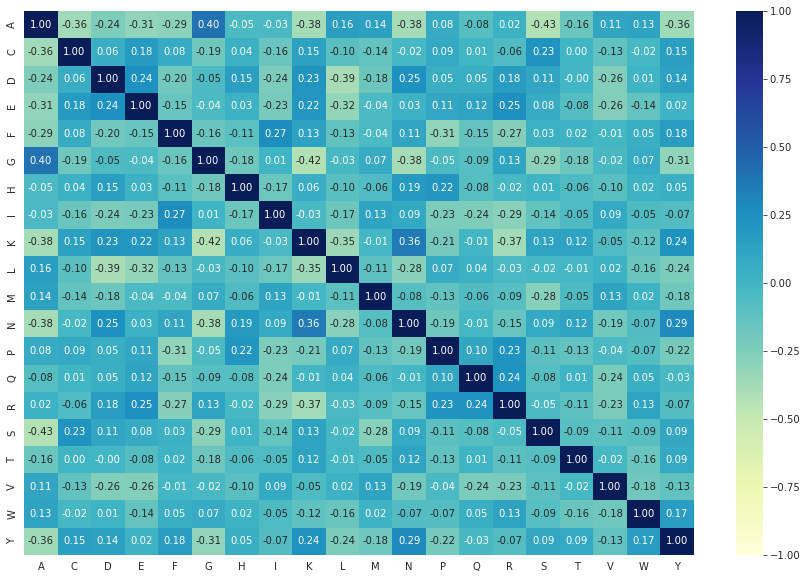

In [25]:
corr_heatmap(df_aac)

<AxesSubplot:>

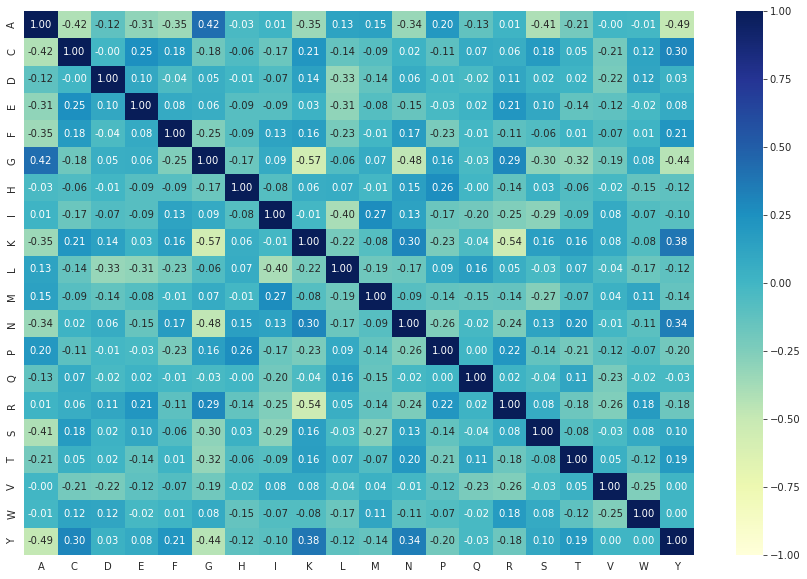

In [26]:
corr_heatmap(df_aac.loc[df[df.keywords_transport == "Sugar transport"].index])

<AxesSubplot:>

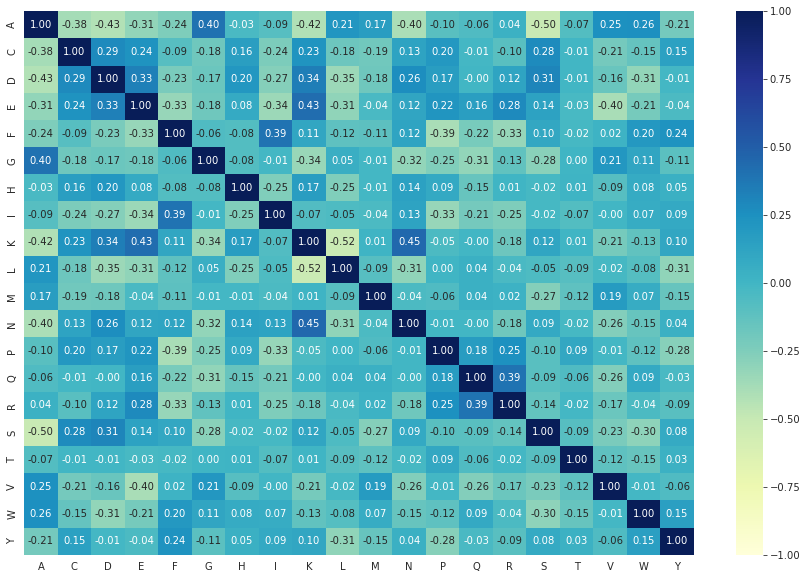

In [27]:
corr_heatmap(df_aac.loc[df[df.keywords_transport == "Amino-acid transport"].index])

#### Distribution

According to shapiro-wilk, most features follow a normal distribution. There is a slight deviation for D (Aspartic acid) and E (Glutamic acid)

<AxesSubplot:>

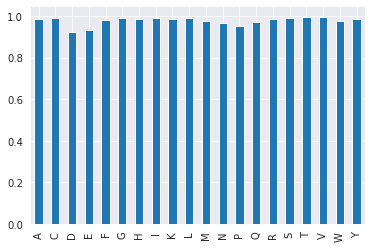

In [28]:
from scipy.stats import shapiro

df_aac.apply(shapiro).loc[0].plot.bar()

##### High Asp

There are three proteins with unusual Asp concentration:

<AxesSubplot:ylabel='Frequency'>

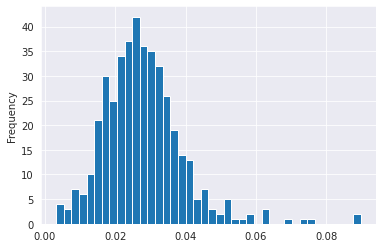

In [29]:
df_aac.D.plot.hist(bins=40)

In [30]:
df.loc[df_aac[df_aac.D > 0.065].index].join(df_aac.P, how="left").drop("sequence", axis=1)

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,organism,P
Uniprot,,,,,,,,,,
Q07837,Amino-acid transport,Membrane;Transmembrane,Transport,SLC3A1 RBAT,Neutral and basic amino acid transport protein...,8.A.9.1.2,8.A,9606,Human,0.040876
P02943,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,lamB malB b4036 JW3996,Maltoporin (Maltose outer membrane channel) (M...,1.B.3.1.1,1.B,83333,E. coli,0.020179
P75733,Ion transport;Polysaccharide transport;Sugar t...,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,chiP ybfM b0681 JW0667,Chitoporin (ChiP-III),1.B.25.1.13,1.B,83333,E. coli,0.029915
P69856,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,nanC yjhA b4311 JW5778,Probable N-acetylneuraminic acid outer membran...,1.B.35.2.1,1.B,83333,E. coli,0.021008
Q9FHH5,Amino-acid transport,Membrane;Transmembrane,Transport,GDU3 LBS1 At5g57685 MRI1.4,Protein GLUTAMINE DUMPER 3 (Protein LESS SUSCE...,NaN,0.0,3702,A. thaliana,0.081081


Again, only outliers that we already know about.

#### High Glu

<AxesSubplot:ylabel='Frequency'>

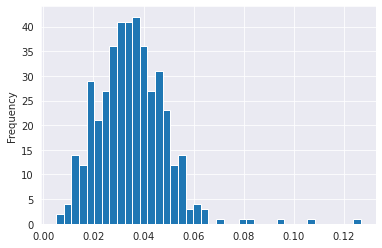

In [31]:
df_aac.E.plot.hist(bins=40)

In [32]:
df.loc[df_aac[df_aac.E > 0.07].index].join(df_aac.P, how="left").drop("sequence", axis=1)

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,organism,P
Uniprot,,,,,,,,,,
Q9HBR0,Amino-acid transport;Ion transport;Sodium tran...,Membrane;Transmembrane,Transport,SLC38A10 PP1744,Putative sodium-coupled neutral amino acid tra...,2.A.18.6.16,2.A,9606,Human,0.091153
O81775,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,GDU1 At4g31730 F28M20.80,Protein GLUTAMINE DUMPER 1,1.A.41.2.2,1.A,3702,A. thaliana,0.044304
Q9FHH5,Amino-acid transport,Membrane;Transmembrane,Transport,GDU3 LBS1 At5g57685 MRI1.4,Protein GLUTAMINE DUMPER 3 (Protein LESS SUSCE...,NaN,0.0,3702,A. thaliana,0.081081
Q8S8A0,Amino-acid transport,Membrane;Transmembrane,Transport,GDU4 At2g24762 F27A10.11,Protein GLUTAMINE DUMPER 4,NaN,0.0,3702,A. thaliana,0.057692
Q3E965,Amino-acid transport,Membrane;Transmembrane,Transport,GDU5 At5g24920 F6A4.130,Protein GLUTAMINE DUMPER 5,NaN,0.0,3702,A. thaliana,0.045802


This is also the case for the high-Glu proteins: GDU and Q9HBRO

## Second analysis, after first outliers have been removed


In [33]:
df = create_dataset(
    keywords_substrate_filter=["Amino-acid transport", "Sugar transport"],
    keywords_component_filter=["Transmembrane"],
    keywords_transport_filter=["Transport"],
    input_file="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="integrate",
    verbose=True,
    tax_ids_filter=[3702, 9606, 83333, 559292],
    output_log="../logs/meta_amino_sugar_dataset.log",
    outliers=["Q9HBR0", "Q07837"]  # human
    + ["P76773", "Q47706", "P02943", "P75733", "P69856", "P64550"]  # Ecoli
    + ["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0"],  # athliana
)
taxid_to_organism = {
    3702: "A. thaliana",
    9606: "Human",
    83333: "E. coli",
    559292: "Yeast",
}
df = df.assign(organism=df.organism_id.map(taxid_to_organism))

In [34]:
df_aac = calculate_aac(df.sequence)
df_paac = calculate_paac(df.sequence)
labels = df.keywords_transport

### PCA Plots



#### AAC

The data is not clearly separable with just the AAC

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

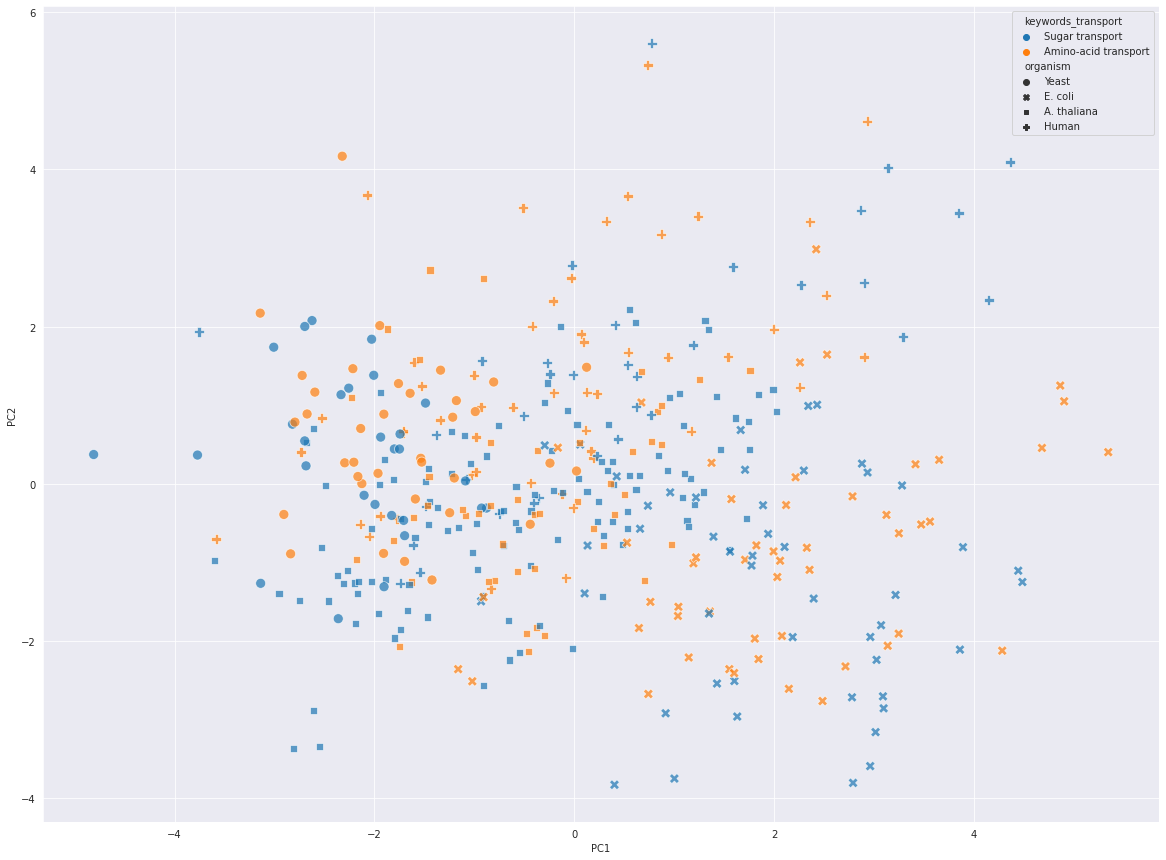

In [35]:
pca_plot_2d(
    df_aac, labels, df.organism, figsize=(20, 15), marker_size=100, marker_opacity=0.7,
)



#### PAAC

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

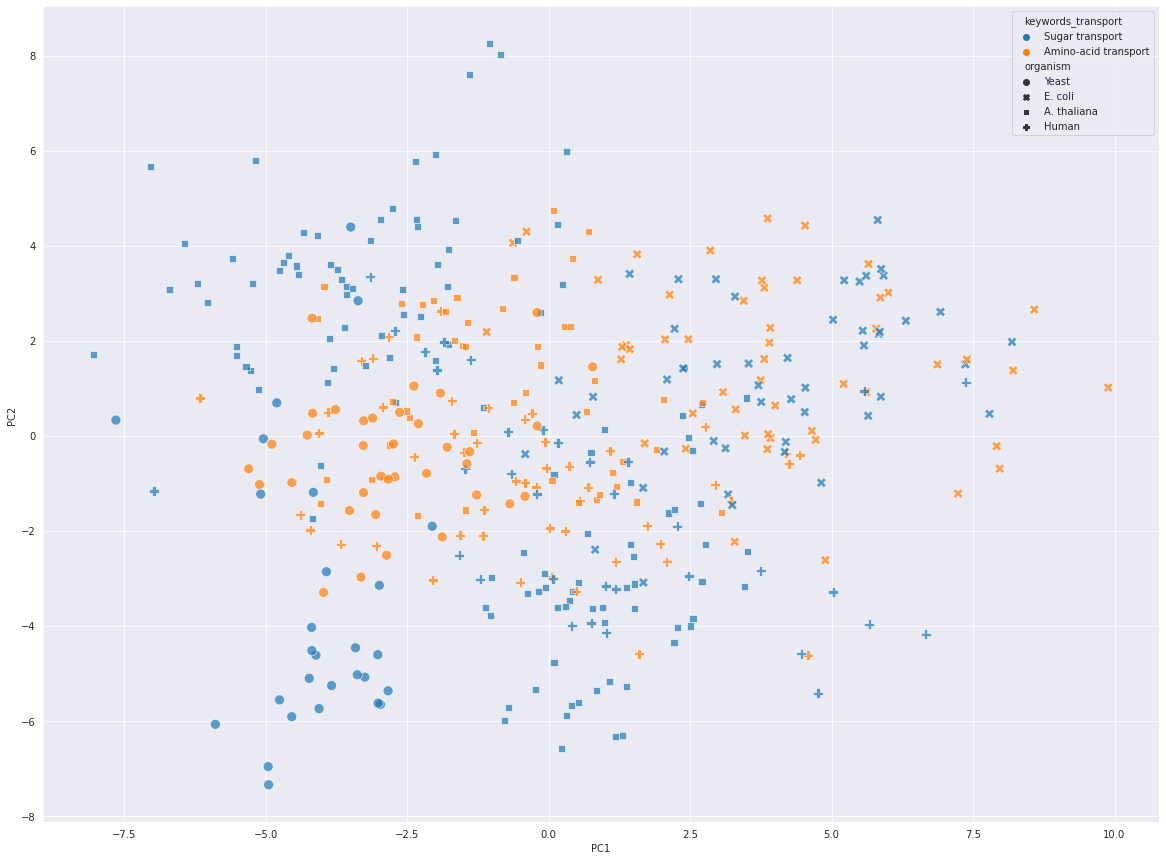

In [36]:
pca_plot_2d(
    df_paac, labels, df.organism, figsize=(20, 15), marker_size=100, marker_opacity=0.7,
)

<Axes3DSubplot:xlabel='PC1', ylabel='PC2'>

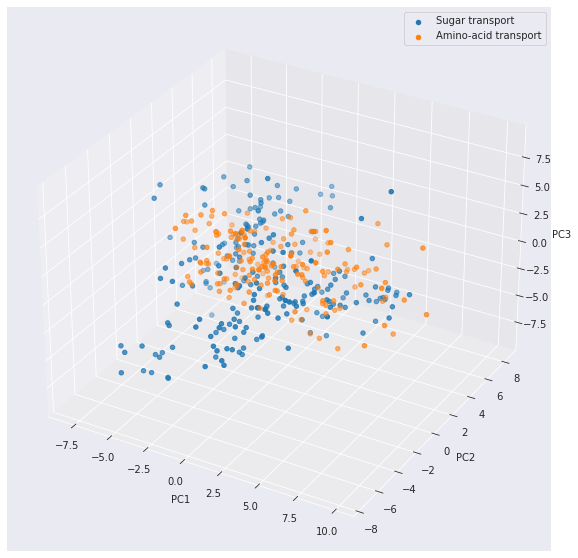

In [37]:
pca_plot_3d(df_paac, labels)

## Summary

For the meta-organism dataset, we found the same outliers that we already found for the individual datasets. In any case, two principal components seem to be not enough for capturing the differences between the classes. More dimensions are needed. 